### Kinetic Analysis of Alanine Dipeptide Simulation Datasets using VAMPnets and MSMs

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
from numpy.linalg import inv
from scipy.linalg import eigh, eig
import scipy.stats as stats
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# MSMBuilder imports
from msmbuilder.featurizer import AtomPairsFeaturizer 
from msmbuilder.dataset import dataset
from msmbuilder.cluster import KCenters, MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel

# Deeptime imports
from deeptime.data import sqrt_model
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset
from deeptime.util.torch import MLP
from deeptime.decomposition.deep import VAMPNet
from deeptime.decomposition import VAMP
from deeptime.clustering import KMeans
from deeptime.markov.msm import MaximumLikelihoodMSM

### Step 1 of MSM and VAMPnets: Generate Features

<img src="fig/alanine_dipeptide.png" width="500" align="center"/>

In [3]:
# Load the list of atom pairs. These pairs define the distances between atoms for which features will be calculated.
atom_pair_list = np.loadtxt('../ala2_atom_pairs.txt') 

# Initialize an atom pair featurizer object.
featurizer = AtomPairsFeaturizer(atom_pair_list)

# For trajectory files with a sequence number less than 10, process and save the features.
for i in range(0, 10):
    # Load the trajectory file and topology, stride=1 means every frame in the trajectory is loaded.
    traj = md.load(f"../ala2-xtc-1ps/ala2-1ps-0{i}.xtc", top="../ala2-xtc-1ps/ala2.pdb", stride=1)
    # Use the featurizer to convert the trajectory into features.
    ftrajs = featurizer.transform([traj])
    # Save the feature array to a file for further analysis.
    np.save(f"features/ftraj_{i}", ftrajs[0])

# For trajectory files with sequence numbers from 10 to 99, process and save the features.
for i in range(10, 100):
    # Load the trajectory file and topology, stride=1 means every frame in the trajectory is loaded.
    traj = md.load(f"../ala2-xtc-1ps/ala2-1ps-{i}.xtc", top="../ala2-xtc-1ps/ala2.pdb", stride=1)
    # Use the featurizer to convert the trajectory into features.
    ftrajs = featurizer.transform([traj])
    # Save the feature array to a file for further analysis.
    np.save(f"features/ftraj_{i}", ftrajs[0])

In [4]:
# Initialize an empty list to hold the features.
features = []

# Loop over 100 trajectory files.
for i in range(100):
    # Load the feature data from each file and append it to the 'features' list.
    features.append(np.load(f'features/ftraj_{i}.npy'))

len(features)

100

### Step 2 of MSM: Generate TICA (Time-lagged Independent Component Analysis)

Autocorrelation Matrix $C_{00} = E_t [x_t x_t^T]$

Cross-Correlation Matrix $C_{01} = E_{t+\tau} [x_{t} x_{t+\tau}^T]$

Koopman Operator $K(\tau) = C_{00}^{-1}C_{01}$

#### Objective of TICA

$(\lambda, V) = \text{eig}[K(\tau)]$

$\chi_k(t) = \sum \Delta d_{(ij)}(t) \cdot V_{(ij),k}$

In [5]:
def compute_TICA(features, lag_time, n_components):
    """
    Compute Time-lagged Independent Component Analysis (TICA).
    
    Parameters:
    - features: List of feature arrays from trajectories.
    - lag_time: The time lag at which to compute the autocorrelation.
    - n_components: Number of components to retain.
    
    Returns:
    - C_0: Covariance matrix at time t.
    - C_tau: Time-lagged covariance matrix at time t + lag_time.
    - K: Kinetic matrix computed from C_0 and C_tau.
    - eigenvectors: Eigenvectors of the kinetic matrix.
    - eigenvalues: Eigenvalues of the kinetic matrix.
    """

    # Concatenate all features to compute overall covariance
    concatenated_features = np.concatenate(features)
    print(concatenated_features.shape)

    # Center the features by subtracting the mean
    mean_features = np.mean(concatenated_features, axis=0)
    concatenated_features -= mean_features

    # Compute time-lagged covariance matrix
    concatenated_lagged_features = np.concatenate([f[lag_time:] for f in features])
    concatenated_current_features = np.concatenate([f[:-lag_time] for f in features])
    
    # Subtract mean for time-lagged and current features
    concatenated_lagged_features -= np.mean(concatenated_lagged_features, axis=0)
    concatenated_current_features -= np.mean(concatenated_current_features, axis=0)

    # Compute covariance matrices
    C_0 = np.dot(concatenated_current_features.T, concatenated_current_features) / concatenated_current_features.shape[0]
    C_tau = np.dot(concatenated_current_features.T, concatenated_lagged_features) / concatenated_lagged_features.shape[0]

    # Compute the kinetic matrix K
    K = np.dot(inv(C_0), C_tau)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(K)
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    return C_0, C_tau, K, eigenvectors, eigenvalues

# Define lag time and the number of components to keep
lag_time = 10 #ps
n_components = 4 

# Compute TICA using the features list
C_0, C_tau, K, eigenvectors, eigenvalues = compute_TICA(features, lag_time, n_components)

# Print the top eigenvalues
print('Top eigenvalues:', eigenvalues[:n_components])

# Transform original features into the TIC space for all trajectories
tic_eigenvectors = eigenvectors[:, :3]  # Selecting first 3 TICs
tic_ftrajs = [f.dot(tic_eigenvectors) for f in features]  # Project features onto the TICs

# Print the number of transformed feature sets
print('tic_ftrajs:', len(tic_ftrajs)) 

(1000100, 45)
[ 0  2  1  3  4  5  8  9 10 29 32 33  6  7 38 26 27 30 31 39 40 24 25 41
 42 44 43 22 23 36 37 34 35 14 15 18 19 28 16 17 20 21 12 13 11]
Top eigenvalues: [0.99381378+0.j 0.85244446+0.j 0.78170386+0.j 0.0500902 +0.j]
tic_ftrajs_list: [array([[-0.0872158 +0.j,  0.00362165+0.j,  0.01024976+0.j],
       [-0.08724233+0.j,  0.00379002+0.j,  0.0104295 +0.j],
       [-0.0872961 +0.j,  0.00501848+0.j,  0.01086304+0.j],
       ...,
       [-0.08750389+0.j,  0.00384515+0.j,  0.01012563+0.j],
       [-0.08711726+0.j,  0.00452395+0.j,  0.01113491+0.j],
       [-0.08708082+0.j,  0.00575439+0.j,  0.01239153+0.j]]), array([[-0.08731792+0.j,  0.00416627+0.j,  0.0108697 +0.j],
       [-0.08706394+0.j,  0.00364002+0.j,  0.01004424+0.j],
       [-0.08720597+0.j,  0.00351621+0.j,  0.0099778 +0.j],
       ...,
       [-0.08711849+0.j,  0.00448968+0.j,  0.01096088+0.j],
       [-0.08708047+0.j,  0.0034363 +0.j,  0.0101787 +0.j],
       [-0.08713722+0.j,  0.0044775 +0.j,  0.01042964+0.j]]), arr

''

### Step 3 of MSM: Generate a Micro State Model

In [6]:
# Initialize the K-Centers clustering algorithm with the desired number of clusters
kcenters = KCenters(n_clusters=400)

# Fit the K-Centers model to the TICA-transformed trajectories
kcenters.fit(tic_ftrajs)

# Transform the TICA-transformed trajectories into discrete states
ktrajs = kcenters.transform(tic_ftrajs)

# Define a function to save the cluster assignments to files for each trajectory
def save_to_files(cluster_assignments, directory="./clusters"):
    
    # Ensure the directory exists, create it if it does not
    os.makedirs(directory, exist_ok=True)
    
    # Save each trajectory's cluster assignments to a separate file
    for i, ktraj in enumerate(cluster_assignments):
        np.save(os.path.join(directory, f"ktraj_{i}"), ktraj)

# Call the function to save the cluster assignments to files
save_to_files(ktrajs)

# Print out the discrete trajectories (cluster assignments)
print(ktrajs)
# Print the number of discrete trajectories
print('ktrajs:', len(ktrajs))

/opt/miniconda3/envs/py37/lib/python3.7/site-packages/msmbuilder/cluster/kcenters.py:82: ComplexWarning: Casting complex values to real discards the imaginary part
  X = X.astype('float64')
/opt/miniconda3/envs/py37/lib/python3.7/site-packages/msmbuilder/cluster/kcenters.py:123: ComplexWarning: Casting complex values to real discards the imaginary part
  X = X.astype('float64')


[array([278, 278, 307, ..., 278,  72, 130]), array([ 72, 353,   0, ...,  72,   0, 154]), array([325, 143, 267, ..., 130,  72,  72]), array([353, 353,   0, ..., 143, 351, 277]), array([  0, 278, 326, ..., 189, 189, 290]), array([  0,  72,  72, ...,  37, 325, 325]), array([ 72,  90, 320, ..., 194,  58, 224]), array([  0, 278, 353, ..., 278, 130,   0]), array([344, 344, 398, ..., 326,  72, 154]), array([  0, 278, 189, ...,   0,   0, 278]), array([  0, 278,   0, ..., 194,  72, 278]), array([143,  91, 143, ..., 278,   0, 278]), array([167, 344, 267, ..., 278,   0, 194]), array([307, 278, 353, ..., 325, 325, 339]), array([278, 224, 278, ..., 259, 326, 146]), array([ 58,   0,   0, ..., 204, 351, 339]), array([278,   0,   0, ...,   0, 307, 278]), array([326, 224,   0, ..., 353, 189,  72]), array([325, 267, 143, ...,   0, 114,   0]), array([278, 166, 154, ..., 304, 109, 109]), array([326,  72,   0, ..., 326,   0,  72]), array([326, 326, 130, ..., 399, 130,  72]), array([  0,  90, 278, ..., 143,

### Step 4-1 of MSM: Build a Macro State Model

Computation of the Transition Count Matrix (TCM):

$C(\tau) = \sum_{t_0} \tilde{x}(t_0 + \tau) \cdot \tilde{x}(t_0)$, which counts the number of transitions between different states of a system after a certain time lag

Normalization to Obtain Transition Probability Matrix (TPM):

$T_{ij}(\tau) = P(X_{t+\tau} = j \,|\, X_t = i) = \frac{C_{ij}(\tau)}{\sum_j C_{ij}(\tau)}$

Obtain Eigenvalues and Eigenvectors:

$(\lambda, R) = \text{eig}[T(\tau)]$

In [9]:
def calculate_transition_probability_matrix(ktrajs, lag_time, n_clusters):
    """
    Calculate the transition probability matrix (TPM) for given cluster trajectories.
    
    Parameters:
    - ktrajs: List of trajectories with discrete states.
    - lag_time: The lag time to use for calculating transitions.
    - n_clusters: The number of clusters/states in the TPM.
    
    Returns:
    - TPM: The normalized transition probability matrix.
    """

    # Initialize a transition count matrix with zeros.
    TCM = np.zeros((n_clusters, n_clusters))
    
    # Count transitions between states at the specified lag time.
    for i in range(len(ktrajs)):
        for j in range(len(ktrajs[i]) - lag_time):
            idx_i = ktrajs[i][j]
            idx_j = ktrajs[i][j + lag_time]
            TCM[idx_i, idx_j] += 1

    # Symmetrize the count matrix by averaging with its transpose.
    TCM = (TCM + TCM.T) / 2
                    
    # Normalize the count matrix to get a transition probability matrix.
    TPM = TCM / np.sum(TCM, axis=1)[:, None]
    
    return TPM

# Calculate the transition probability matrix using the cluster trajectories.
TPM = calculate_transition_probability_matrix(ktrajs, 1, 400)

# Calculate the eigenvalues and eigenvectors of the transition probability matrix.
R_eigenvalues, R_eigenvectors = np.linalg.eig(TPM)

# Sort the eigenvalues and eigenvectors in descending order of eigenvalues.
idx = np.argsort(-R_eigenvalues)
R_eigenvalues = R_eigenvalues[idx]
R_eigenvectors = R_eigenvectors[:, idx]

# Print the shape of the eigenvalues array and the first 5 eigenvalues.
print(R_eigenvalues.shape)
print(R_eigenvalues[:5])

# Print the shape of the eigenvectors matrix and the first 5 eigenvectors.
print(R_eigenvectors.shape)
print(R_eigenvectors[:, :5])

(400,)
[1.         0.99909908 0.980319   0.94087918 0.29737692]
(400, 400)
[[ 5.00000000e-02 -2.24837053e-03 -3.91480514e-02 -9.96845785e-06
  -3.31977655e-03]
 [ 5.00000000e-02  7.79828568e-02  1.39610691e-03 -1.13935235e-02
   1.04818365e-04]
 [ 5.00000000e-02 -2.36443729e-03  9.81874292e-02 -7.82331185e-06
  -1.40452301e-02]
 ...
 [ 5.00000000e-02 -2.24295094e-03 -3.89889226e-02 -1.11516914e-05
  -2.59050800e-03]
 [ 5.00000000e-02 -2.36128328e-03  9.44006363e-02 -7.87222026e-06
   1.29641644e-02]
 [ 5.00000000e-02 -2.25149270e-03 -3.66387326e-02 -1.00553747e-05
   9.43379406e-03]]


### Step 4-2 of MSM: Build a Macro State Model

**Perron Cluster-Cluster Analysis (PCCA)**

PCCA is utilized to dissect the sign structure of the top right eigenvectors derived from a transition probability matrix. This dissection aids in identifying the boundaries between different macrostates in the context of Markov State Models (MSM).

- **Stationary Eigenvector**:
  - The right eigenvector that corresponds to the eigenvalue $\lambda_0 = 1$ represents the stationary distribution and is typically a vector of ones, denoted by  $V_0 = [1, 1, \ldots, 1]$. This particular eigenvector does not provide information about transitions between states and is, therefore, not utilized in state assignment within PCCA.

- **Transition Modes**:
  - Eigenvectors that are not associated with the eigenvalue $\lambda = 1$ are termed transition modes $V_i$. These eigenvectors are instrumental in segregating states based on their components' signs. For each state $j$:
    - If $V_{ij} > 0$, the state is assigned to one macrostate.
    - If $V_{ij} \leq 0$, the state is assigned to a different macrostate.

- **State Division Principles**:
  - For an MSM that is characterized by $n$ states, there exist $n - 1$ transition modes. Each transition mode $V_i$ is utilized to bifurcate a single state into two distinct parts. It's crucial to avoid splitting more than one state per transition mode, ensuring clarity and consistency in the clustering of microstates into macrostates.


In [10]:
class PCCA:
    # Initialize the PCCA class with the desired number of macrostates
    def __init__(self, n_macrostates):
        self.n_macrostates = n_macrostates
        self.microstate_mapping_ = np.array([])

    # Fit the PCCA model to the right eigenvectors of the transition matrix
    def fit(self, right_eigenvectors):
        # Check if the eigenvector matrix is square
        assert right_eigenvectors.shape[0] == right_eigenvectors.shape[1]
        n_states = right_eigenvectors.shape[0]

        # Initialize a mapping array from microstates to macrostates
        microstate_mapping = np.zeros(n_states, dtype=int)

        # For each macrostate, assign microstates based on the signs of the eigenvector components
        for i in range(1, self.n_macrostates):
            v = right_eigenvectors[:, i]  # i-th eigenvector
            state_diff = []
            threshold = 1e-4  # A threshold for deciding state assignments

            # Assign microstates to macrostates based on the sign of their component in the eigenvector
            if i > 1:
                # Further assignments for states beyond the first macrostate
                for state in np.unique(microstate_mapping):
                    state_indices = np.where(microstate_mapping == state)[0]
                    state_signs = np.sign(v[state_indices])
                    # Calculate the balance of positive and negative signs
                    num_positive = np.sum(state_signs >= 0)
                    num_negative = np.sum(state_signs == -1)
                    diff = abs(num_positive - num_negative)
                    state_diff.append((diff, state))

                # Choose the state with the minimum difference for splitting
                split_state = min(state_diff)[1]

                # Update the microstate mapping for the current macrostate
                split_indices = np.where((microstate_mapping == split_state) & (v >= threshold))
                microstate_mapping[split_indices] = i
            else:
                # Initial assignment for the first macrostate
                idx = np.where(v >= threshold)
                microstate_mapping[idx] = i

        self.microstate_mapping_ = microstate_mapping

    # Transform a sequence of microstates to the corresponding macrostates
    def transform(self, sequence):
        if len(self.microstate_mapping_) > 0:
            return [self.microstate_mapping_[seq] for seq in sequence]
        else:
            raise ValueError("Model not fitted yet")
    
# Instantiate the PCCA class and fit it to the right eigenvectors
n_macrostates = 4
pcca = PCCA(n_macrostates)
pcca.fit(R_eigenvectors)
macrostates = pcca.transform(ktrajs)

# Save the macrostate assignments to files in a specified directory
def save_to_files(macrostate_assignment, directory="./macro4"):
    os.makedirs(directory, exist_ok=True)  # Create the directory if it doesn't exist
    
    for i, macrostates in enumerate(macrostate_assignment):
        # Write each macrostate sequence to a file
        with open(os.path.join(directory, f"macro_{i}.txt"), "w") as file:
            for assignment in macrostates:
                file.write(f"{assignment}\n")

# Call the function to save the macrostate assignments
save_to_files(macrostates)

# Print a sample of the macrostate assignments
print(macrostates[1:2])

# Print the unique macrostates discovered
macro = np.unique(macrostates)
print(macro)

400
(400,)
0.0008862965468311627
6.555913667551415e-05
30
152
split state 0
4.705960146928671e-06
98
30
126
split state 1
[array([0, 0, 0, ..., 0, 0, 0])]
[0 1 2 3]


### Step 5 of MSM: Build MSM

MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.50. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.33. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.25. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.20. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.17. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.14. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.12. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.11. Component 0 selected, with popula

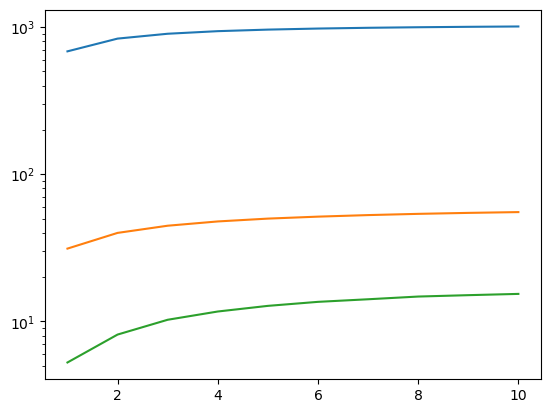

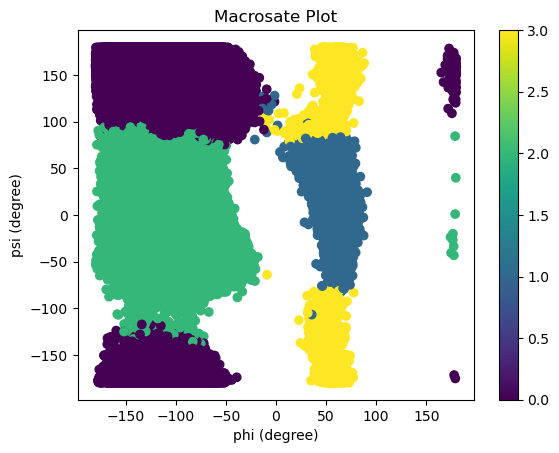

In [11]:
from msmbuilder.msm import MarkovStateModel

# Load macrostate trajectory data from text files
macro4_trajs = []
for i in range(100):
    this_traj = np.loadtxt(f"./macro4/macro_{i}.txt", dtype=int)
    macro4_trajs.append(this_traj)

# Load Ramachandran angle data (phi, psi angles) from text files
ramas = []
for i in range(10):
    ramas.append(np.loadtxt(f"../ala2-xtc-1ps/rama-traj/ala2-1ps-0{i}.txt"))
for i in range(10, 100):
    ramas.append(np.loadtxt(f"../ala2-xtc-1ps/rama-traj/ala2-1ps-{i}.txt"))

# Initialize a list to store timescales from Markov State Model (MSM) at different lag times
msm_timescales = []

# Loop over a range of lag times to compute MSM timescales
macro_lagtimes = range(1, 11)
for macro_lagtime in macro_lagtimes:
    msm = MarkovStateModel(n_timescales=3, lag_time=macro_lagtime)
    msm.fit(macro4_trajs)
    msm_timescales.append(msm.timescales_)

# Plot the timescales for each state at different lag times
for j in range(len(msm_timescales[0])):
    plt.plot(macro_lagtimes, [timescale[j] for timescale in msm_timescales])

plt.yscale('log')
plt.show()

# Function to convert state sequences into one-hot encoding
def one_hot_of_all(trajs, num_states):
    one_hot_states = []
    for traj in trajs:
        one_hot_traj = np.eye(num_states)[traj]
        one_hot_states.append(one_hot_traj)
    return one_hot_states

# Concatenate all the macrostate and dihedral angle data
assignments = np.concatenate(macro4_trajs)
dihedrals = np.concatenate(ramas)

# Scatter plot of the dihedral angles colored by macrostate assignments
plt.scatter(dihedrals[:, 0], dihedrals[:, 1], c=assignments, cmap='viridis')
plt.colorbar()

plt.xlabel('phi (degree)')
plt.ylabel('psi (degree)')
plt.title('Macrosate Plot')
plt.show()

### Step 6 of VAMPnets: Build a VAMPnets Model

In [12]:
import mdshare  

# Check if CUDA (an API for parallel computing using GPUs) is available, and set the device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")  
    torch.backends.cudnn.benchmark = True  
else:
    device = torch.device("cpu")  

torch.set_num_threads(12) 

In [13]:
# Download the coordinates file for alanine dipeptide simulations and store it locally in the 'data' directory
ala_coords_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-heavy-atom-positions.npz", working_directory="data"
)

# Load the heavy atom position data from the .npz file into a list of numpy arrays and convert to float32 for numerical operations
with np.load(ala_coords_file) as fh:
    data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]

# Download the dihedrals file for alanine dipeptide simulations and store it locally in the 'data' directory
dihedral_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-backbone-dihedrals.npz", working_directory="data"
)

# Load the backbone dihedral angle data from the .npz file into a list of numpy arrays
with np.load(dihedral_file) as fh:
    dihedral = [fh[f"arr_{i}"] for i in range(3)]

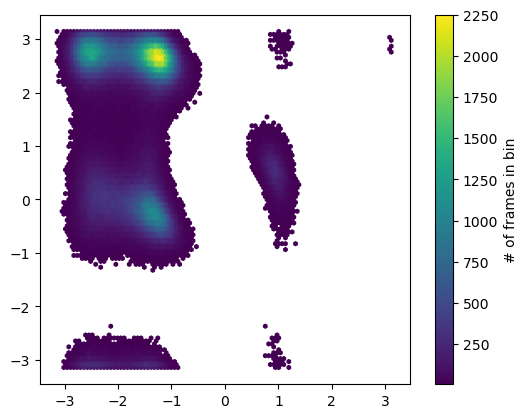

In [14]:
# Create a single subplot (1x1 grid) and store the figure and axes objects in variables 'f' and 'ax'
f, ax = plt.subplots(1, 1)

# Plot a hexbin graph, which is a two-dimensional histogram with hexagonal bins, using the dihedral angles
hb = ax.hexbin(*np.concatenate(dihedral).T, mincnt=5)

# Set the aspect of the plot to 'equal' to ensure that one unit on the x-axis is equal to one unit on the y-axis
ax.set_aspect('equal')
cb = f.colorbar(hb, ax=ax)
cb.set_label('# of frames in bin')

In [15]:
# Create a dataset from the numpy array 'data' with a lagtime of 1 for time-lagged independent component analysis (TICA)
dataset = TrajectoriesDataset.from_numpy(1, data)

# Determine the size of the validation set as 10% of the total dataset
n_val = int(len(dataset) * 0.1)  # Calculate 10% of the dataset size to be used for validation

# Split the dataset into training and validation sets using the calculated size
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

In [16]:
# Construct a neural network architecture (lobe) for use in VAMPNets, which is a framework for analyzing MD data
lobe = nn.Sequential(
    nn.BatchNorm1d(data[0].shape[1]), 
    nn.Linear(data[0].shape[1], 20), nn.ELU(), 
    nn.Linear(20, 20), nn.ELU(),  
    nn.Linear(20, 20), nn.ELU(),  
    nn.Linear(20, 20), nn.ELU(),  
    nn.Linear(20, 20), nn.ELU(), 
    nn.Linear(20, 6), 
    nn.Softmax(dim=1)  
)

# Move the neural network model to the specified 'device' (GPU or CPU)
lobe = lobe.to(device=device)

# Print the architecture of the neural network to verify its structure
print(lobe)

Sequential(
  (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=30, out_features=20, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=20, out_features=20, bias=True)
  (6): ELU(alpha=1.0)
  (7): Linear(in_features=20, out_features=20, bias=True)
  (8): ELU(alpha=1.0)
  (9): Linear(in_features=20, out_features=20, bias=True)
  (10): ELU(alpha=1.0)
  (11): Linear(in_features=20, out_features=6, bias=True)
  (12): Softmax(dim=1)
)


In [17]:
# Initialize a VAMPNet object with the previously defined 'lobe' neural network, a set learning rate, and the specified device
vampnet = VAMPNet(lobe=lobe, learning_rate=5e-3, device=device)

# Create a DataLoader for the training data
loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)

# Create a DataLoader for the validation data
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [18]:
model = vampnet.fit(loader_train, n_epochs=10,
                    validation_loader=loader_val, progress=tqdm).fetch_model()

VAMPNet epoch:   0%|          | 0/10 [00:00<?, ?it/s]

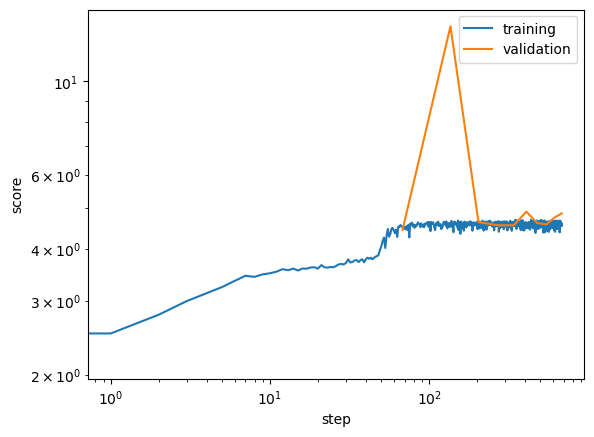

In [19]:
# Plot the VAMPNet training and validation scores using a log-log scale
plt.loglog(*vampnet.train_scores.T, label='training') 
plt.loglog(*vampnet.validation_scores.T, label='validation')  

# Set the label for the x-axis as 'step' to represent the training step or iteration number
plt.xlabel('step')

# Set the label for the y-axis as 'score' to represent the VAMP score at each training step
plt.ylabel('score')

# Display a legend to differentiate between the training and validation score lines
plt.legend()

# Show the plot on the screen (the semicolon at the end suppresses the output of the last command line in Jupyter Notebooks)
plt.show()

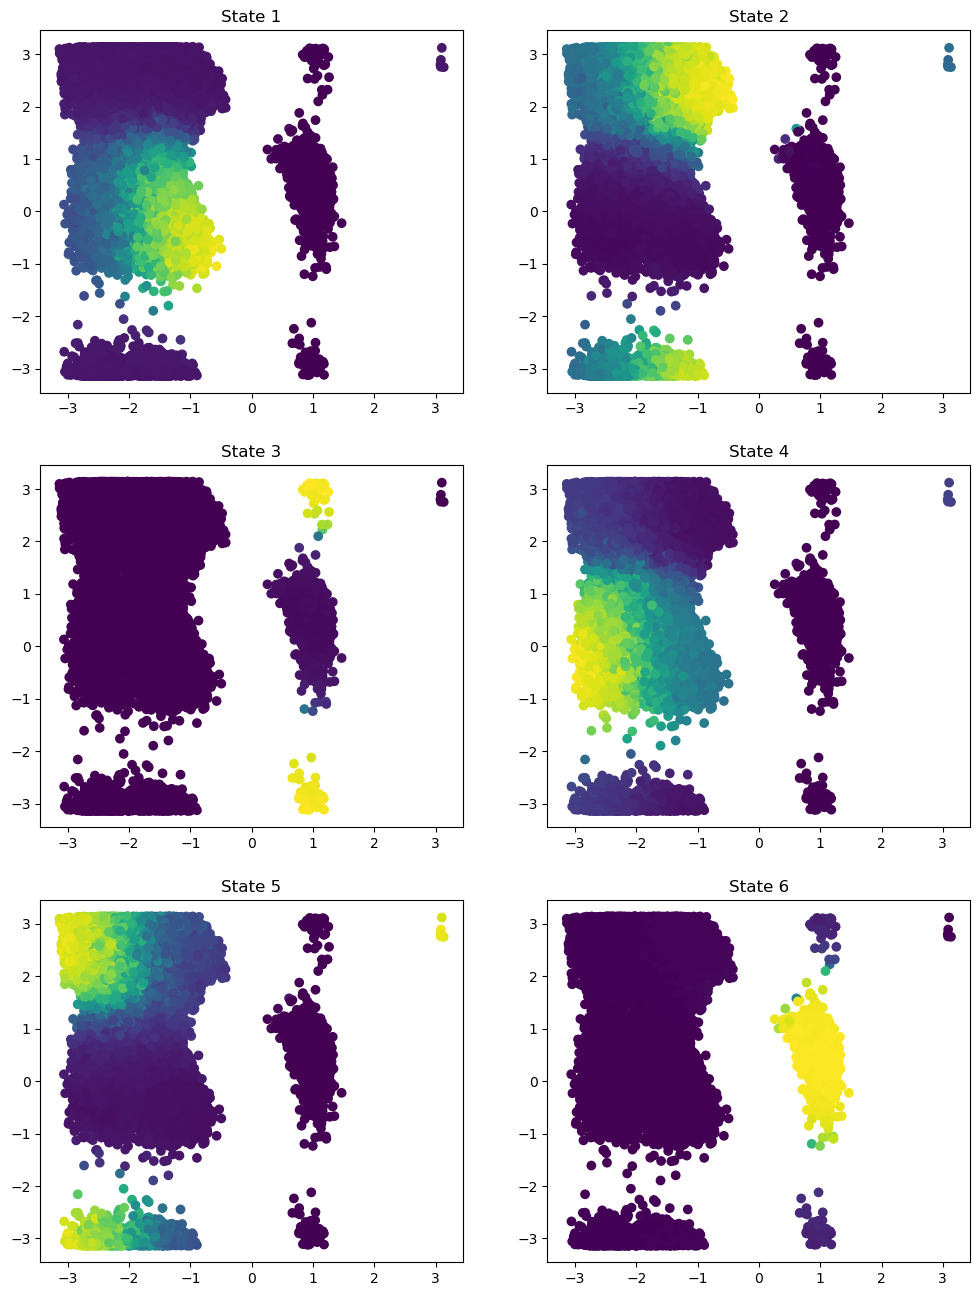

In [20]:
# Transform the first trajectory in your dataset into state probabilities
state_probabilities = model.transform(data[0])

# Create a figure with 3x2 subplots, setting the figure size to 12x16 inches for clarity
f, axes = plt.subplots(3, 2, figsize=(12, 16))

# Loop over each subplot axis and the corresponding state probability
for i, ax in enumerate(axes.flatten()):
    # Scatter plot of the dihedral angles for the first trajectory, subsampled by taking every 5th point
    ax.scatter(*dihedral[0][::5].T, c=state_probabilities[..., i][::5])
    # Set the title of each subplot to indicate which state's probabilities are being plotted
    ax.set_title(f'State {i+1}')

In [21]:
# Assignment probability rate by lobe
state_probabilities = model.transform(data[0])
for ix, (mini, maxi) in enumerate(zip(np.min(state_probabilities, axis=0), np.max(state_probabilities, axis=0))):
    print(f"State {ix+1}: [{mini}, {maxi}]")

State 1: [2.3236640117829666e-05, 0.6872985363006592]
State 2: [6.262131591938669e-06, 0.841881275177002]
State 3: [0.0013173379702493548, 0.9191235303878784]
State 4: [8.35981518321205e-06, 0.7981628775596619]
State 5: [2.038868615272804e-06, 0.5322213172912598]
State 6: [0.0010048002004623413, 0.9761852622032166]


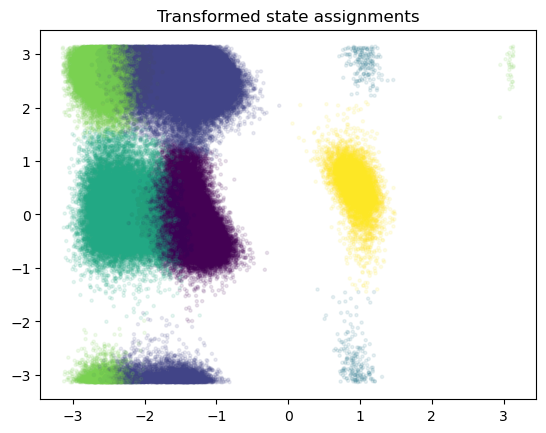

In [22]:
# 6 Transformed state assignmnets
assignments = state_probabilities.argmax(1)

plt.scatter(*dihedral[0].T, c=assignments, s=5, alpha=.1)
plt.title('Transformed state assignments');

In [23]:
# Vamp model from transform 
vamp_estimator = VAMP(lagtime=10, observable_transform=model)
vamp = vamp_estimator.fit(data).fetch_model()
print(f"VAMP-2 score under lag 10: s = {vamp.score(2).round(2)}")

VAMP-2 score under lag 10: s = 3.28


  0%|          | 0/9 [00:00<?, ?it/s]

Text(0, 0.5, 'timescale')

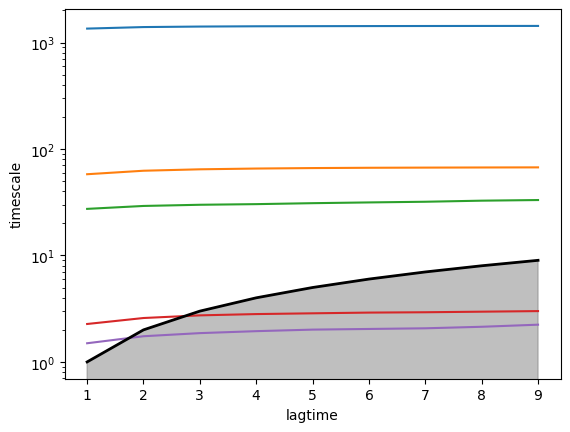

In [25]:
# Plot to see which lagtime data behave like Markovian
lagtimes = np.arange(1, 10, dtype=np.int32)
vamp_models = [VAMP(lagtime=lag, observable_transform=model).fit_fetch(data) for lag in tqdm(lagtimes)]

ax = plot_implied_timescales(implied_timescales(vamp_models))
ax.set_yscale('log')
ax.set_xlabel('lagtime')
ax.set_ylabel('timescale')